# Libraries and Databases

In [1]:
# Importing the necessary libraries:
# - pandas: data manipulation and processing
# - matplotlib: graphical visualization
# - yfinance: download of historical stock prices
# - datetime and mdates: date formatting and time axis handling
# - time: delay control to avoid API rate limiting
# - os: handling of local directories (file reading)

from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import os
import pandas as pd
import time
import yfinance as yf

In [2]:
os.chdir(os.path.join(os.getcwd(), 'Databases'))

In [3]:
# Loads the consolidated ROIC data per asset
df_ROIC = pd.read_excel("ROIC_database.xlsx", index_col="Asset")
df_ROIC.head()

,2024,2023,2022,2021,2020,2019,2018
Asset,,,,,,,
brav3,0.0705,0.0742,-0.0131,0.0839,-0.1155,-0.0807,0.0857
csan3,0.0028,0.1126,0.0735,0.1057,0.0804,0.1173,0.1071
petr3,0.1612,0.1999,0.3228,0.2321,0.0617,0.1004,0.077
recv3,0.145,0.1217,0.2434,0.0872,0.1045,0.0307,0.1729
prio3,0.0621,0.2659,0.1926,0.1858,0.1603,0.2131,0.104


In [4]:
# Loads the consolidated EV/EBIT data per asset
df_EV_EBIT = pd.read_excel("EV_EBIT_database.xlsx", index_col="Asset")
df_EV_EBIT.head()

,2024,2023,2022,2021,2020,2019,2018
Asset,,,,,,,
brav3,9.69,10.79,29.1,10.45,-23.21,-,-
csan3,20.34,6.44,9.64,8.46,16.77,9.75,7.59
petr3,6,3.84,1.94,3.1,14.14,8.88,9.36
recv3,5.79,9.95,6.96,16.11,-,-,-
prio3,7.81,6.72,8.29,8.2,12.58,6.66,4.73


# Data Processing

#### Creating a function to preprocess and rank dataframes

In [5]:
def preprocess_and_rank(df, metric_name="Metric", drop_asset_years=None):
    """
    Preprocesses and ranks a wide-format financial DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with assets as index and years as columns
        metric_name (str): Name to assign to the metric column (default: 'Metric')
        drop_asset_years (dict): Optional dictionary of assets and list of years to exclude, e.g.:
                                 {"PORT3": [2018, 2019, 2020]}
        
    Returns:
        pd.DataFrame: Cleaned and ranked DataFrame with columns [Asset, Year, metric_name, Ranking]
    """
    # Reorder columns so years go from oldest to most recent
    df = df[df.columns[::-1]]
    
    # Standardize asset names
    df.index = df.index.str.upper()
    
    # Move index to column
    df = df.reset_index()
    df = df.rename(columns={"index": "Asset"})
    
    # Melt the DataFrame
    df = df.melt(id_vars="Asset", var_name="Year", value_name=metric_name)
    
    # Drop specified asset-year combinations if provided
    if drop_asset_years:
        for asset, years in drop_asset_years.items():
            df = df[~((df["Asset"] == asset) & (df["Year"].isin(years)))]
    
    # Clean the metric column
    df[metric_name] = df[metric_name].astype(str).str.strip().str.replace(",", ".")
    df[metric_name] = df[metric_name].str.replace(r"[^\d\.\-]", "", regex=True)
    df[metric_name] = pd.to_numeric(df[metric_name], errors="coerce")
    
    # Drop invalid entries
    df = df.dropna(subset=[metric_name]).copy()
    
    # Rank assets by year
    df["Ranking"] = df.groupby("Year")[metric_name].rank(ascending=False, method="min")
    df["Ranking"] = df["Ranking"].astype("Int64")
    
    # Sort for readability
    df = df.sort_values(by=["Year", "Ranking"]).reset_index(drop=True)
    
    return df

In [6]:
def calculate_ey_from_ev_ebit(df_ev_ebit_ranked):
    """
    Calculates Earnings Yield (EY = 1 / EV/EBIT) from a cleaned EV/EBIT DataFrame.

    Parameters:
        df_ev_ebit_ranked (DataFrame): Output from preprocess_and_rank()

    Returns:
        DataFrame: Contains EY values and rankings per year
    """
    df = df_ev_ebit_ranked.copy()
    
    # Apply inversion: EY = 1 / EV/EBIT
    df["Metric"] = df["Metric"].apply(lambda x: 1 / x if pd.notnull(x) and x != 0 else None)

    # Drop invalid values
    df = df.dropna(subset=["Metric"])

    # Recalculate ranking for EY (higher is better)
    df["Ranking"] = df.groupby("Year")["Metric"].rank(ascending=False, method="min")
    df["Ranking"] = df["Ranking"].astype("Int64")

    # Sort for readability
    df = df.sort_values(by=["Year", "Ranking"]).reset_index(drop=True)

    return df

#### Return on Invested Capital (ROIC)

In [7]:
df_ROIC_ranked = preprocess_and_rank(df_ROIC, metric_name="Metric", drop_asset_years={"PORT3": [2018, 2019, 2020]})
df_ROIC_ranked.head()

,Asset,Year,Metric,Ranking
0,LAVV3,2018,0.4448,1
1,GOLL4,2018,0.4276,2
2,AERI3,2018,0.3319,3
3,BLAU3,2018,0.3297,4
4,MGLU3,2018,0.3234,5


#### Earning Yield (EBIT/EV)

In [8]:
# Preprocess EV/EBIT data: reshape, clean, and rank
df_EV_EBIT_ranked = preprocess_and_rank(df_EV_EBIT, metric_name="Metric")

# Compute Earnings Yield (EY = 1 / EV/EBIT) from the preprocessed DataFrame
df_EY = calculate_ey_from_ev_ebit(df_EV_EBIT_ranked)

# Preview the resulting EY DataFrame
df_EY.head()

,Asset,Year,Metric,Ranking
0,WIZC3,2018,0.281690,1
1,FRAS3,2018,0.246305,2
2,ELET3,2018,0.225734,3
3,PRIO3,2018,0.211416,4
4,PSSA3,2018,0.204918,5


# Backtesting estratégia

#### Criação de funções necessárias à avaliação

In [9]:
def build_magic_formula_portfolio(df_ROIC, df_EY, n_assets):
    """
    Builds and simulates the Magic Formula portfolio for the Brazilian market.

    Parameters:
        df_ROIC (DataFrame): DataFrame with ROIC ranking by asset and year
        df_EY (DataFrame): DataFrame with EY ranking by asset and year
        n_assets (int): Number of assets to include in each annual portfolio

    Returns:
        DataFrame with daily and cumulative returns of the portfolio and IBOV
    """

    # Merges both rankings based on "Asset" and "Year"
    df = pd.merge(
        df_ROIC[["Asset", "Year", "Ranking"]],
        df_EY[["Asset", "Year", "Ranking"]],
        on=["Asset", "Year"],
        suffixes=("_ROIC", "_EY")
    )

    # Calculates total ranking as the sum of individual rankings (lower is better)
    df["Total_Ranking"] = df["Ranking_ROIC"] + df["Ranking_EY"]

    results = []  # List to store results for each year
    cumulative_capital = 1  # Starts with 1 to compute cumulative return
    cumulative_capital_ibov = 1  # Same for IBOV
    years = sorted(df["Year"].unique())  # List of available years

    # Loop through each year to build the portfolio
    for year in years:

        # Selects the top N assets with the best total ranking for that year
        df_year = df[df["Year"] == year].sort_values("Total_Ranking").head(n_assets)
        assets = df_year["Asset"].tolist()

        # Formats tickers to Yahoo Finance standard (.SA for Brazilian stocks)
        tickers = [asset if "." in asset else asset + ".SA" for asset in assets]

        # Defines the backtest period: the year after the selection
        start = f"{year + 1}-01-01"
        end = f"{year + 1}-12-31"

        try:
            # Downloads closing prices of selected assets and IBOV
            df_prices = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=False)["Adj Close"]
            time.sleep(1)  # Pause to avoid rate limiting
            ibov = yf.download("^BVSP", start=start, end=end, progress=False, auto_adjust=False)["Adj Close"]
            time.sleep(2)
        except Exception as e:
            print(f"⚠️  Error downloading data for year {year + 1}: {e}")
            continue

        # Verifies if data was successfully downloaded
        if df_prices.empty or ibov.empty:
            print(f"⚠️  Data not available for year {year + 1}. Skipping...")
            continue

        # Calculates the portfolio's daily and cumulative returns (equal weighting)
        df_return = df_prices.pct_change().dropna()
        df_return["Daily Return"] = df_return.mean(axis=1)
        df_return["Cumulative Return"] = (1 + df_return["Daily Return"]).cumprod() * cumulative_capital
        cumulative_capital = df_return["Cumulative Return"].iloc[-1]

        # Processes IBOV return over the same period
        ibov.index = pd.to_datetime(ibov.index)
        ibov = ibov.reindex(df_return.index)
        ibov_daily_return = ibov.pct_change().fillna(0)
        ibov_cumulative_return = (1 + ibov_daily_return).cumprod() * cumulative_capital_ibov
        cumulative_capital_ibov = ibov_cumulative_return.iloc[-1]

        # Organizes results of the year in a DataFrame
        df_result = df_return[["Daily Return", "Cumulative Return"]].copy()
        df_result["Date"] = df_result.index
        df_result["Base Year"] = year
        df_result["Assets"] = ", ".join(assets)

        # Adds IBOV data aligned to the portfolio dates
        df_result["IBOV Points"] = ibov.reindex(df_result["Date"]).values
        df_result["IBOV Daily Return"] = ibov_daily_return.reindex(df_result["Date"]).fillna(0).values
        df_result["IBOV Cumulative Return"] = ibov_cumulative_return.reindex(df_result["Date"]).ffill().values

        # Stores this year's results
        results.append(df_result)

    # Ensure at least one year was processed successfully
    if not results:
        raise ValueError("No return data was generated. Check if tickers and dates are correct.")

    # Concatenates all years into a single final DataFrame
    df_final = pd.concat(results).reset_index(drop=True)
    
    return df_final[[ 
        "Date", "Base Year", "Assets",
        "Daily Return", "Cumulative Return",
        "IBOV Points", "IBOV Daily Return", "IBOV Cumulative Return"
    ]]

#### Resultados

In [10]:
def backtesting_magic_formula(df_ROIC, df_EY, list_n_assets):
    """
    Performs Magic Formula backtesting for different portfolio sizes.
    Displays a styled plot highlighting the 2020 crisis with annotated final returns.

    Parameters:
        df_ROIC (DataFrame): ROIC ranking by asset and year
        df_EY (DataFrame): Earnings Yield ranking by asset and year
        list_n_assets (list of int): List with different asset counts to test (e.g., [5, 10, 20])

    Returns:
        None. Only displays the comparison plot.
    """

    # Internal function to format quarters on the X-axis
    def format_quarter(x, pos):
        date = mdates.num2date(x)
        year = str(date.year)[-2:]  # Only get the last two digits of the year
        month = date.month
        quarter = (month - 1) // 3 + 1
        return f"{quarter}Q{year}"

    fig, ax = plt.subplots(figsize=(14, 7))
    results = []

    for n in list_n_assets:
        try:
            df_result = build_magic_formula_portfolio(df_ROIC, df_EY, n_assets=n)
            results.append((n, df_result))

            # Plot portfolio performance
            ax.plot(
                df_result["Date"],
                df_result["Cumulative Return"],
                label=f"Magic Formula - {n} assets"
            )

            # Annotate final portfolio return
            final_value = df_result["Cumulative Return"].iloc[-1]
            final_date = df_result["Date"].iloc[-1]
            ax.annotate(f"{final_value:.2f}x",
                        xy=(final_date, final_value),
                        xytext=(5, 0),
                        textcoords="offset points",
                        fontweight="bold",
                        fontsize=10,
                        va="center",
                        color="black")

        except Exception as e:
            print(f"Error processing {n} assets: {e}")

    # Plot IBOV (from the last successful result)
    if results:
        _, df_result = results[-1]

        ax.plot(
            df_result["Date"],
            df_result["IBOV Cumulative Return"],
            label="IBOV",
            linestyle="--",
            color="black",
            linewidth=1.5,
            dashes=(6, 4)
        )

        # Annotate final IBOV return
        ibov_final_value = df_result["IBOV Cumulative Return"].iloc[-1]
        ibov_final_date = df_result["Date"].iloc[-1]
        ax.annotate(f"{ibov_final_value:.2f}x",
                    xy=(ibov_final_date, ibov_final_value),
                    xytext=(5, 0),
                    textcoords="offset points",
                    fontweight="bold",
                    fontsize=10,
                    va="center",
                    color="black")

    # Highlight the COVID-19 crisis
    pandemic_start = datetime(2020, 2, 20)
    pandemic_end = datetime(2020, 4, 10)
    pandemic_mid = pandemic_start + (pandemic_end - pandemic_start) / 2

    ax.axvspan(pandemic_start, pandemic_end, color='lightgray', alpha=0.5)
    ax.text(pandemic_mid, ax.get_ylim()[1] * 0.90,
            "COVID-19", color="red", fontsize=8, fontweight="bold",
            ha="center")

    # X-axis: apply quarter formatter
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_quarter))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", fontsize=9)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="center", fontsize=9)
    
    # Aesthetics and layout
    ax.set_title("Magic Formula Backtest", fontsize=14, fontweight="bold")
    ax.set_ylabel("Cumulative Return (Multiplier)", fontsize=9)

    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.grid(axis="x", which='major', linestyle='', alpha=0)

    ax.legend()
    fig.tight_layout()
    plt.show()

In [11]:
df_results = build_magic_formula_portfolio(df_ROIC_ranked, df_EY, 1)
df_results.tail()

C:\Users\marcu\AppData\Local\Temp\ipykernel_56816\4022568467.py:81: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_result["IBOV Cumulative Return"] = ibov_cumulative_return.reindex(df_result["Date"]).fillna(method="ffill").values
C:\Users\marcu\AppData\Local\Temp\ipykernel_56816\4022568467.py:81: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_result["IBOV Cumulative Return"] = ibov_cumulative_return.reindex(df_result["Date"]).fillna(method="ffill").values
C:\Users\marcu\AppData\Local\Temp\ipykernel_56816\4022568467.py:81: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_result["IBOV Cumulative Return"] = ibov_cumulative_return.reindex(df_result["Date"]).fillna(method="ffill").values
C:\Users\marcu\AppData\Local

Ticker,Date,Base Year,Assets,Daily Return,Cumulative Return,IBOV Points,IBOV Daily Return,IBOV Cumulative Return
1567,2025-05-05,2024,PLPL3,-0.039312,4.847182,133491.00000,-0.012158,1.575986
1568,2025-05-06,2024,PLPL3,0.014493,4.917431,133516.00000,0.000187,1.576282
1569,2025-05-07,2024,PLPL3,0.003361,4.933960,133398.00000,-0.000884,1.574889
1570,2025-05-08,2024,PLPL3,0.036851,5.115781,136232.00000,0.021245,1.608347
1571,2025-05-09,2024,PLPL3,0.072698,5.487688,136556.53125,0.002382,1.612178


In [32]:
df_results[df_results["Date"] == "2019-12-30"]

Ticker,Date,Base Year,Assets,Daily Return,Cumulative Return,IBOV Points,IBOV Daily Return,IBOV Cumulative Return
246,2019-12-30,2018,PTBL3,-0.005556,1.025981,115964.0,-0.004891,1.26648


C:\Users\marcu\AppData\Local\Temp\ipykernel_56816\4022568467.py:81: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_result["IBOV Cumulative Return"] = ibov_cumulative_return.reindex(df_result["Date"]).fillna(method="ffill").values
C:\Users\marcu\AppData\Local\Temp\ipykernel_56816\4022568467.py:81: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_result["IBOV Cumulative Return"] = ibov_cumulative_return.reindex(df_result["Date"]).fillna(method="ffill").values
C:\Users\marcu\AppData\Local\Temp\ipykernel_56816\4022568467.py:81: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_result["IBOV Cumulative Return"] = ibov_cumulative_return.reindex(df_result["Date"]).fillna(method="ffill").values
C:\Users\marcu\AppData\Local

C:\Users\marcu\AppData\Local\Temp\ipykernel_56816\4022568467.py:81: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_result["IBOV Cumulative Return"] = ibov_cumulative_return.reindex(df_result["Date"]).fillna(method="ffill").values
C:\Users\marcu\AppData\Local\Temp\ipykernel_56816\4022568467.py:81: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_result["IBOV Cumulative Return"] = ibov_cumulative_return.reindex(df_result["Date"]).fillna(method="ffill").values
C:\Users\marcu\AppData\Local\Temp\ipykernel_56816\4022568467.py:81: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_result["IBOV Cumulative Return"] = ibov_cumulative_return.reindex(df_result["Date"]).fillna(method="ffill").values
C:\Users\marcu\AppData\Local

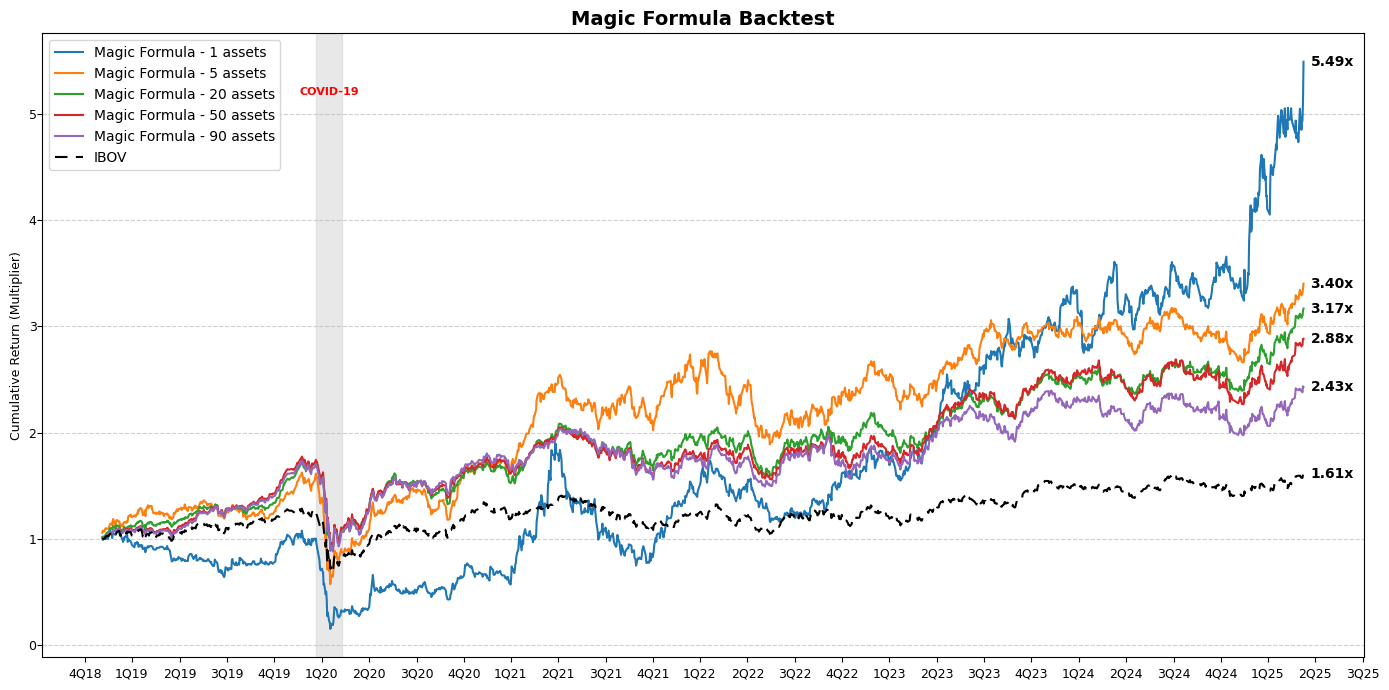

In [29]:
backtesting_magic_formula(df_ROIC_ranked, df_EY, [1, 5, 20, 50, 90])